In [1]:
import numpy as np
import pandas as pd
from numpy.random import shuffle
from numpy.random import randint
from random import choice
# %matplotlib widget
import matplotlib.pyplot as plt
import sys
import copy
import random
import math
import networkx as nx
import os

## Convert gml graph to 2D matrix

In [2]:
def read_graph_from_gml(file_name):
  gml_file = nx.read_gml(file_name)
  A = nx.adjacency_matrix(gml_file)
  t = A.toarray()
  for iy, ix in np.ndindex(t.shape):
      if t[iy, ix] == 1:
          t[iy, ix] = random.randint(1, 10)
  graph = np.maximum( t, t.transpose() )

  return graph

In [3]:
# Representing the graph using adjacent graph
# 
class Graph(object):

    # Initialize the matrix
    def __init__(self, adj_matrix):
        self.adj_matrix = adj_matrix
        self.size = len(adj_matrix)

    # Add edges
    def add_edge(self, v1, v2, dist):
        if v1 == v2:
            print("Same vertex %d and %d" % (v1, v2))
        self.adj_matrix[v1][v2] = dist
        self.adj_matrix[v2][v1] = dist

    # Remove edges
    def remove_edge(self, v1, v2):
        if self.adj_matrix[v1][v2] == 0:
            print("No edge between %d and %d" % (v1, v2))
            return
        self.adj_matrix[v1][v2] = 0
        self.adj_matrix[v2][v1] = 0

    def __len__(self):
        return self.size


    # Print the matrix
    def print_matrix(self):
        print(np.matrix(self.adj_matrix))


In [4]:
# The postman that need to deliver packages. 
class Postman(object):
    
    def __init__(self, size=None, salary=0, speed_matrix=None):
      # speed[i][k]: speed on link i to k
      self.speed_matrix = self.gen_speed_matrix(size) if size != None else speed_matrix
      # time_matrix[i] = time to node_i
      self.time_matrix = []
      self.salary  = self.gen_salary() if salary == 0 else salary

    def set_time_matrix(self, time_matrix):
      self.time_matrix = time_matrix
    
    def gen_speed_matrix(self, size):
      speed_matrix = [[0 for i in range(size)] for j in range(size)]

      for i in range(size):
        for j in range(i, size):
          speed_matrix[i][j] = random.randint(1, 10)
          speed_matrix[j][i] = speed_matrix[i][j]
      return speed_matrix
    
    def gen_salary(self):
      return random.randint(1, 10)
    
    def to_dict(self):
      return {
          'speed_matrix': self.speed_matrix,
          'time_matrix': self.time_matrix,
          'salary': self.salary
      }

In [22]:
# for each gml file in the sample_graph folder, convert it to a graph object and get the size of the graph.
# Based on the size of the graph, generate postmen and their speed matrix. The length of postmen is the 0.2 of the size of the graph.
# Similarly, the demands are generated based on the size of the graph. The length of demands should be 3 times of the size of the graph.
# The demands are generated randomly.
# Store the postmen and demands in different file named by the gml file name.
def generate_postmen_and_demands():
    for gml_file in os.listdir('sample_graph'):
        adj_matrix = read_graph_from_gml('sample_graph/' + gml_file)
        graph = Graph(adj_matrix)
        size = len(graph)
        postmen = []
        demands = []
        for i in range(int(size * 0.2)):
            postmen.append(Postman(size=size))
        for i in range(int(size * 3)):
            demands.append(random.randint(0, size - 1))
        with open('postmen/' + gml_file + '.txt', 'w') as f:
            dict_postmen = {}
            for idx, postman in enumerate(postmen):
                dict_postmen[idx] = postman.to_dict()
            f.write(str(dict_postmen))
        with open('demands/' + gml_file + '.txt', 'w') as f:
            f.write(str(demands))

# Read the postmen and demands from the file.
def read_postmen_and_demands(gml_file):
    postmen = []
    with open('postmen/' + gml_file + '.txt', 'r') as f:
        dict_postmen = eval(f.read())
        for _, postman in dict_postmen.items():
            postmen.append(Postman(speed_matrix=postman['speed_matrix'], salary=postman['salary']))
    with open('demands/' + gml_file + '.txt', 'r') as f:
        demands = eval(f.read())
    return postmen, demands
    # for gml_file in os.listdir('sample_graph'):
    #     postmen = []
    #     print(gml_file)
    #     with open('postmen/' + gml_file + '.txt', 'r') as f:
    #         dict_postmen = eval(f.read())
    #         for _, postman in dict_postmen.items():
    #             postmen.append(Postman(speed_matrix=postman['speed_matrix'], salary=postman['salary']))
    #     with open('demands/' + gml_file + '.txt', 'r') as f:
    #         demands = eval(f.read())
    #     return postmen, demands

# generate_postmen_and_demands()

In [6]:
class Chromosome(object):
  def __init__(self, assignment, finish_time, postmen_cost):
    self.assignment = assignment
    self.finish_time = finish_time
    self.postmen_cost = postmen_cost
    self.fitness = 0
  
  def __str__(self) -> str:
     return f'Assignment {self.assignment} would deliver all packages in {self.finish_time} minutes, with postmen_cost {self.postmen_cost}'

In [7]:
class Model(object):
  def __init__(self, graph, postmen, demands):
    self.graph = graph.adj_matrix
    self.num_node = len(graph.adj_matrix)
    self.postmen = postmen
    self.cost_matrixs = []
    self.demands = demands

    for postman in self.postmen:
      single_cost_matrix = np.divide(self.graph, postman.speed_matrix)
      self.cost_matrixs.append(single_cost_matrix)
      postman.set_time_matrix(self.dijkstra(0, single_cost_matrix))
  
  def printSolution(self, dist):
    print("Vertex \tDistance from Source")
    for node in range(self.num_node):
      print(node, "\t", dist[node])

  def minDistance(self, dist, sptSet):
  
    # Initialize minimum distance for next node
    min = sys.maxsize
    min_index = 0

    # Search not nearest vertex not in the
    # shortest path tree
    for u in range(self.num_node):
      if dist[u] < min and sptSet[u] == False:
        min = dist[u]
        min_index = u

    return min_index

  def dijkstra(self, src, graph):
  
    dist = [sys.maxsize] * self.num_node
    dist[src] = 0
    sptSet = [False] * self.num_node

    for cout in range(self.num_node):

      # Pick the minimum distance vertex from
      # the set of vertices not yet processed.
      # x is always equal to src in first iteration
      x = self.minDistance(dist, sptSet)

      # Put the minimum distance vertex in the
      # shortest path tree
      sptSet[x] = True

      # Update dist value of the adjacent vertices
      # of the picked vertex only if the current
      # distance is greater than new distance and
      # the vertex in not in the shortest path tree
      for y in range(self.num_node):
        if graph[x][y] > 0 and sptSet[y] == False and \
              dist[y] > dist[x] + graph[x][y]:
          dist[y] = dist[x] + graph[x][y]

    # self.printSolution(dist)
    return dist

  def gen_population(self, population_size):
    population = []
    for i in range(population_size):
        population.append(self.gen_random_route())
    return population
  
  def gen_random_route(self):
    assignments = [random.randint(0, len(self.postmen) - 1) for i in range(len(self.demands))]
    #print(f'assignment = {assignments}')
    return self.get_chromosome(assignments)


  def get_chromosome(self, assignments):
    #available_time[i] = the time when postman i is available
    available_time = [0 for _ in range(len(self.postmen))]
    timer = 0
    ptr = 0
    while ptr < len(assignments):
      postman_idx = assignments[ptr]
      while available_time[postman_idx] > timer:
        timer += 1
      #print(len(self.postmen), len(self.postmen[0].time_matrix), postman_idx, self.demands[ptr])
      available_time[postman_idx] = self.postmen[postman_idx].time_matrix[self.demands[ptr]]*2 + timer
      ptr += 1
    postmen_cost = 0
    for postman_idx in set(assignments):
      postmen_cost += self.postmen[postman_idx].salary
    return Chromosome(assignments, max(available_time), postmen_cost)



#**Chromosome representation:**
A list of packages, where each element of the list represents a package and its value represents the postman assigned to deliver that package.

For example: if we have 5 packages and 3 postmen, a chromosome could be represented as [1, 2, 1, 3, 2], where the first package is assigned to postman 1, the second to postman 2, the third to postman 1 again, the fourth to postman 3, and the fifth to postman 2 again.


In [60]:
from IPython.core.display import deepcopy

class Gene(object):

  def __init__(self, graph, postmen, demands, population_size=100, mutation_rate=0.01, num_generations=300, crossover_method="single_point", uniform_crossover_rate=0.3, mutation_operator = "swap", terminal_fitness=0.4, converge_step = 10, overtime_penalty = 1.5, regulated_time = 30):

    self.demands = demands
    self.population_size = population_size
    self.mutation_rate = mutation_rate
    self.num_generations = num_generations
    self.model = Model(graph, postmen, demands)
    self.population = []
    self.crossover_method = crossover_method
    self.mutation_operator = mutation_operator
    self.uniform_crossover_rate = uniform_crossover_rate
    self.overtime_penalty = overtime_penalty
    self.regulated_time = regulated_time
    self.best_each_iter = []
    self.max_converge_step = converge_step
    self.converge_count = 0
    self.curr_fitness = 0
    self.curr_best_fitness = 0
    self.terminal_fitness = 1 / regulated_time
    self.terminal = False

  def evolution(self):
    while len(self.best_each_iter) <= self.num_generations:
      self.evolve_population()
      if self.check_termination():
        break
    cross_mutate_method = self.crossover_method + ", " + self.mutation_operator + ": "
    print(cross_mutate_method + "terminated by maximum num of generations")

  def eval_fitness(self, chromosome):
    # return 1/(chromosome.finish_time+chromosome.postmen_cost)
    return 1/((chromosome.finish_time-self.regulated_time)*self.overtime_penalty + chromosome.postmen_cost)

  def create_population(self):
      self.population = self.model.gen_population(self.population_size)
      #return self.population

  def single_point_crossover(self, parent1, parent2):
      crossover_position = random.randint(1, len(self.demands) - 1)
      tmp = copy.deepcopy(parent1)
      tmp.assignment[crossover_position:] = parent2.assignment[crossover_position:]

      return tmp

  def two_points_crossover(self, parent1, parent2):
      # how long the exchange part would be
      cross_len = math.floor(len(self.demands) / 5)
      cross_pos = random.randint(1, len(self.demands) - cross_len)
      tmp = copy.deepcopy(parent1)
      tmp.assignment[cross_pos:cross_pos + cross_len] = parent2.assignment[cross_pos:cross_pos + cross_len]

      return tmp
  
  def multi_points_crossover(self, parent1, parent2):
      multi_points_num = math.floor(len(self.demands) / 5) + 1
      points = random.sample(range(len(self.demands)), multi_points_num)
      tmp = copy.deepcopy(parent1)
      for point in points:
        tmp.assignment[point] = parent2.assignment[point]
      
      return tmp

  def uniform_crossover(self, parent1, parent2):
      tmp = copy.deepcopy(parent1) 
      for i in range(len(tmp.assignment)):
        if random.random() < self.uniform_crossover_rate:
          tmp.assignment[i] = parent2.assignment[i]
      
      return tmp

  def insert_mutation(self, chromosome):
      if random.random() < self.mutation_rate:
          index1 = random.randint(0, len(self.demands)-1)
          index2 = random.randint(0, len(self.demands)-1)
          chromosome.assignment.insert(index1, chromosome.assignment.pop(index2))

  def inversion_mutation(self, chromosome):
      if random.random() < self.mutation_rate:
          index1 = random.randint(0, len(self.demands)-1)
          index2 = random.randint(index1, len(self.demands)-1)
          chromosome.assignment[index1:index2] = chromosome.assignment[index1:index2][::-1]

  def swap_mutation(self, chromosome):
      if random.random() < self.mutation_rate:
          index1 = random.randint(0, len(self.demands)-1)
          index2 = random.randint(0, len(self.demands)-1)
          chromosome.assignment[index1], chromosome.assignment[index2] = chromosome.assignment[index2], chromosome.assignment[index1]
  
  def scramble_mutation(self, chromosome):
      if random.random() < self.mutation_rate:
          index1 = random.randint(0, len(self.demands)-1)
          index2 = random.randint(0, len(self.demands)-1)
          chromosome.assignment[index1:index2] = random.sample(chromosome.assignment[index1:index2], len(chromosome.assignment[index1:index2]))

  def select_parents(self):
      # parent selection
      fitness_sum = sum([self.eval_fitness(chromosome) for chromosome in self.population])
      threshold = random.uniform(0, fitness_sum)
      fitness_sum = 0
      for chromosome in self.population:
          fitness_sum += self.eval_fitness(chromosome)
          if fitness_sum > threshold:
              return chromosome
      return self.population[-1]

  def evolve_population(self):
      new_population = []
      while len(new_population) < self.population_size:
          parent1 = self.select_parents()
          parent2 = self.select_parents()
          child = None
          match self.crossover_method:
            case "single_point":
              child = self.single_point_crossover(parent1, parent2)
            case "two_points":
              child = self.two_points_crossover(parent1, parent2)
            case "multi_points":
              child = self.multi_points_crossover(parent1, parent2)
            case "uniform":
              child = self.uniform_crossover(parent1, parent2)
          match self.mutation_operator:
            case "insert":
              self.insert_mutation(child)
            case "inversion":
              self.inversion_mutation(child)
            case "swap":
              self.swap_mutation(child)
            case "scramble":
              self.scramble_mutation(child)
          child = self.model.get_chromosome(child.assignment)
          child.fitness = self.eval_fitness(child)
          new_population.append(child)
      self.population = new_population
      best_chromosome = self.get_best_chromosome()
      self.best_each_iter.append(best_chromosome)
      if best_chromosome.fitness == self.curr_best_fitness:
        self.converge_count += 1
      else:
        self.converge_count = 0
        self.curr_best_fitness = best_chromosome.fitness
      return new_population

  def get_best_chromosome(self):
      best_chromosome = self.population[0]
      best_fitness = self.eval_fitness(best_chromosome)
      fitness_sum = 0
      for chromosome in self.population:
          fitness = self.eval_fitness(chromosome)
          fitness_sum += fitness
          if fitness > best_fitness:
              best_fitness = fitness
              best_chromosome = chromosome
      self.curr_fitness = fitness_sum / self.population_size
      return best_chromosome
  
  def check_termination(self):
    if (self.curr_fitness >= self.terminal_fitness) or (self.converge_count >= self.max_converge_step):
      cross_mutate_method = self.crossover_method + ", " + self.mutation_operator + ": "
      print(cross_mutate_method + "terminated by fitness" if self.curr_fitness >= self.terminal_fitness else cross_mutate_method + "terminated by converge")
      return True
    else:
      return False
  
  def print_fitness_evolution(self):
    x = list(range(1, len(self.best_each_iter) + 1))
    y = []
    for chromosome in self.best_each_iter:
      y.append(chromosome.fitness)

    plt.plot(x, y)
      
    plt.xlabel('Evolution Steps')
    plt.ylabel('Fitness')
    plt.title(self.crossover_method + ", " + self.mutation_operator)
    
    return plt

## Generate graph, postmen, demands.

In [45]:
gml_name = 'atlanta--D-B-M-N-C-A-N-N.gml'
gml_file_name = 'sample_graph/' + gml_name
graph = read_graph_from_gml(gml_file_name)
graph_size = len(graph)
num_postmen = 8
num_demands = 100
g = Graph(adj_matrix=graph)
postmen, demands = read_postmen_and_demands(gml_name)

In [46]:
gene = Gene(graph=g,
      postmen=postmen,
      demands=demands,
      population_size=100,
      mutation_rate=0.02,
      num_generations=1000,
      crossover_method="uniform",
      mutation_operator="swap",
      uniform_crossover_rate=0.3,
      terminal_fitness=0.2,
      converge_step=20)
gene.create_population()
gene.evolution()

uniform, swap: terminated by converge


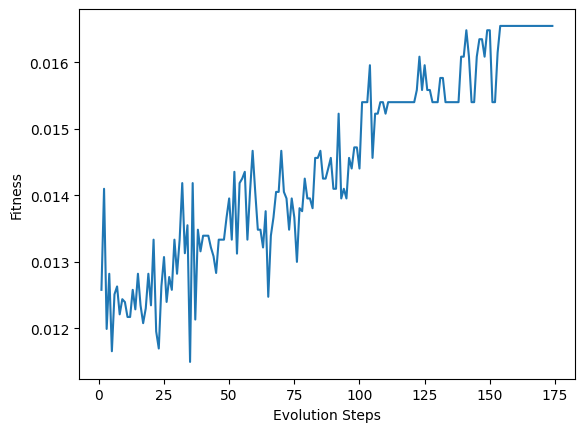

In [47]:
plt = gene.print_fitness_evolution()
plt.show()

In [56]:

adj_matrix = [[0,0,0,0,0,32,75,40,0,0,0,0,0,0,0],
              [0,0,20,0,18,24,0,0,0,0,0,0,0,0,0],
              [0,20,0,0,27,0,0,54,0,0,0,0,0,0,0],
              [0,0,0,0,66,30,0,0,0,0,0,0,0,0,0],
              [0,18,27,66,0,0,0,0,0,0,0,0,0,0,0],
              [32,24,0,30,0,0,0,0,0,0,0,0,44,0,0],
              [75,0,0,0,0,0,0,0,0,48,0,0,0,56,0],
              [40,0,54,0,0,0,0,0,20,0,0,0,0,0,62],
              [0,0,0,0,0,0,0,20,0,16,0,64,0,0,72],
              [0,0,0,0,0,0,48,0,16,0,0,84,0,0,0],
              [0,0,0,0,0,0,0,0,0,0,0,0,18,46,0],
              [0,0,0,0,0,0,0,0,64,84,0,0,0,0,0],
              [0,0,0,0,0,44,0,0,0,0,18,0,0,32,0],
              [0,0,0,0,0,0,56,0,0,0,46,0,32,0,0],
              [0,0,0,0,0,0,0,62,72,0,0,0,0,0,0]]
g = Graph(adj_matrix=adj_matrix)

postman1Speed = [[ 4.,  3.,  8.,  7.,  1.,  7.,  6.,  5.,  4.,  5.,  2.,  6.,  3.,
         4.,  6.],
       [ 3.,  7.,  5.,  6.,  4.,  6.,  8.,  6.,  4.,  6.,  8.,  7.,  5.,
         6.,  3.],
       [ 8.,  5.,  9.,  3.,  2.,  1.,  6.,  5.,  1.,  4.,  6.,  7.,  5.,
         7.,  9.],
       [ 7.,  6.,  3.,  8.,  7.,  6.,  5.,  8.,  4.,  7.,  7.,  6.,  3.,
         3.,  8.],
       [ 1.,  4.,  2.,  7.,  9.,  6.,  8.,  7.,  3.,  8.,  5.,  3.,  2.,
         7.,  8.],
       [ 7.,  6.,  1.,  6.,  6.,  3.,  5.,  5.,  3., 10.,  2.,  4.,  3.,
         8.,  2.],
       [ 6.,  8.,  6.,  5.,  8.,  5.,  5.,  4.,  5.,  6.,  1.,  5.,  2.,
         3.,  3.],
       [ 5.,  6.,  5.,  8.,  7.,  5.,  4.,  1.,  4.,  6.,  4.,  8.,  6.,
         5.,  3.],
       [ 4.,  4.,  1.,  4.,  3.,  3.,  5.,  4.,  2.,  3.,  4.,  6.,  6.,
         7.,  7.],
       [ 5.,  6.,  4.,  7.,  8., 10.,  6.,  6.,  3.,  1.,  6.,  5.,  6.,
         4.,  5.],
       [ 2.,  8.,  6.,  7.,  5.,  2.,  1.,  4.,  4.,  6.,  9.,  6.,  9.,
         5.,  4.],
       [ 6.,  7.,  7.,  6.,  3.,  4.,  5.,  8.,  6.,  5.,  6.,  1.,  7.,
         5.,  6.],
       [ 3.,  5.,  5.,  3.,  2.,  3.,  2.,  6.,  6.,  6.,  9.,  7.,  1.,
         4.,  5.],
       [ 4.,  6.,  7.,  3.,  7.,  8.,  3.,  5.,  7.,  4.,  5.,  5.,  4.,
        10.,  4.],
       [ 6.,  3.,  9.,  8.,  8.,  2.,  3.,  3.,  7.,  5.,  4.,  6.,  5.,
         4.,  2.]]
postman2Speed = [[7., 7., 7., 4., 2., 5., 7., 9., 5., 8., 7., 3., 3., 8., 8.],
       [7., 2., 3., 5., 7., 7., 4., 7., 7., 8., 3., 3., 7., 4., 7.],
       [7., 3., 2., 8., 3., 5., 7., 3., 2., 4., 4., 6., 5., 3., 6.],
       [4., 5., 8., 4., 8., 7., 9., 6., 7., 5., 6., 2., 4., 9., 6.],
       [2., 7., 3., 8., 2., 7., 4., 3., 3., 3., 5., 8., 5., 4., 8.],
       [5., 7., 5., 7., 7., 2., 3., 2., 5., 4., 6., 5., 9., 5., 4.],
       [7., 4., 7., 9., 4., 3., 5., 6., 7., 5., 7., 9., 2., 5., 8.],
       [9., 7., 3., 6., 3., 2., 6., 1., 7., 7., 5., 3., 5., 8., 6.],
       [5., 7., 2., 7., 3., 5., 7., 7., 5., 6., 4., 4., 7., 3., 3.],
       [8., 8., 4., 5., 3., 4., 5., 7., 6., 5., 5., 5., 6., 5., 8.],
       [7., 3., 4., 6., 5., 6., 7., 5., 4., 5., 2., 6., 8., 4., 4.],
       [3., 3., 6., 2., 8., 5., 9., 3., 4., 5., 6., 4., 7., 6., 2.],
       [3., 7., 5., 4., 5., 9., 2., 5., 7., 6., 8., 7., 2., 4., 9.],
       [8., 4., 3., 9., 4., 5., 5., 8., 3., 5., 4., 6., 4., 9., 2.],
       [8., 7., 6., 6., 8., 4., 8., 6., 3., 8., 4., 2., 9., 2., 9.]]
postman3Speed = [[8., 5., 8., 4., 4., 5., 4., 4., 6., 5., 6., 7., 3., 2., 3.],
       [5., 3., 5., 3., 3., 3., 8., 8., 5., 5., 9., 5., 4., 3., 8.],
       [8., 5., 3., 7., 1., 6., 1., 4., 5., 4., 9., 6., 7., 7., 4.],
       [4., 3., 7., 3., 6., 6., 5., 5., 2., 6., 4., 4., 7., 2., 6.],
       [4., 3., 1., 6., 9., 6., 8., 3., 1., 5., 6., 5., 6., 5., 5.],
       [5., 3., 6., 6., 6., 9., 6., 7., 6., 4., 3., 4., 8., 2., 1.],
       [4., 8., 1., 5., 8., 6., 9., 7., 9., 4., 4., 6., 4., 7., 7.],
       [4., 8., 4., 5., 3., 7., 7., 7., 7., 6., 6., 6., 4., 8., 7.],
       [6., 5., 5., 2., 1., 6., 9., 7., 3., 2., 4., 7., 5., 2., 3.],
       [5., 5., 4., 6., 5., 4., 4., 6., 2., 8., 4., 4., 5., 3., 4.],
       [6., 9., 9., 4., 6., 3., 4., 6., 4., 4., 8., 2., 8., 3., 3.],
       [7., 5., 6., 4., 5., 4., 6., 6., 7., 4., 2., 5., 5., 6., 2.],
       [3., 4., 7., 7., 6., 8., 4., 4., 5., 5., 8., 5., 7., 6., 9.],
       [2., 3., 7., 2., 5., 2., 7., 8., 2., 3., 3., 6., 6., 2., 3.],
       [3., 8., 4., 6., 5., 1., 7., 7., 3., 4., 3., 2., 9., 3., 6.]]

postman4Speed = [[ 1.,  4.,  3.,  5.,  9.,  6.,  7.,  9.,  3.,  4.,  2.,  6.,  6.,
         4.,  5.],
       [ 4.,  8.,  6.,  2.,  8.,  2.,  6.,  6., 10.,  2.,  6.,  5.,  6.,
         7.,  3.],
       [ 3.,  6.,  5.,  7.,  6.,  2.,  1.,  8.,  4.,  5.,  3.,  2.,  6.,
         6.,  7.],
       [ 5.,  2.,  7.,  8.,  5.,  5.,  5.,  3.,  2.,  6.,  2.,  2.,  4.,
         5.,  5.],
       [ 9.,  8.,  6.,  5.,  1.,  5.,  3.,  8.,  7.,  4.,  5.,  5.,  6.,
         6.,  4.],
       [ 6.,  2.,  2.,  5.,  5.,  2.,  9.,  8.,  9.,  8.,  6.,  3.,  5.,
         3.,  5.],
       [ 7.,  6.,  1.,  5.,  3.,  9.,  2.,  6.,  3.,  6.,  6.,  6.,  8.,
         8.,  5.],
       [ 9.,  6.,  8.,  3.,  8.,  8.,  6.,  3.,  6.,  5.,  2.,  2.,  5.,
         8.,  6.],
       [ 3., 10.,  4.,  2.,  7.,  9.,  3.,  6., 10.,  6.,  9.,  5.,  8.,
         8.,  7.],
       [ 4.,  2.,  5.,  6.,  4.,  8.,  6.,  5.,  6.,  8.,  4.,  4.,  4.,
         7.,  4.],
       [ 2.,  6.,  3.,  2.,  5.,  6.,  6.,  2.,  9.,  4.,  6.,  5.,  4.,
         2.,  8.],
       [ 6.,  5.,  2.,  2.,  5.,  3.,  6.,  2.,  5.,  4.,  5.,  7.,  5.,
         5.,  3.],
       [ 6.,  6.,  6.,  4.,  6.,  5.,  8.,  5.,  8.,  4.,  4.,  5.,  5.,
         4.,  4.],
       [ 4.,  7.,  6.,  5.,  6.,  3.,  8.,  8.,  8.,  7.,  2.,  5.,  4.,
         2.,  5.],
       [ 5.,  3.,  7.,  5.,  4.,  5.,  5.,  6.,  7.,  4.,  8.,  3.,  4.,
         5.,  1.]]
postman5Speed = [[ 4.,  5.,  9.,  6.,  6.,  5.,  8.,  9.,  4.,  1.,  5.,  8.,  8.,
         8.,  3.],
       [ 5.,  1.,  4.,  9.,  5.,  5.,  5.,  2.,  5.,  3.,  6.,  3.,  5.,
         6.,  7.],
       [ 9.,  4.,  6.,  7.,  4.,  7.,  9.,  4.,  6.,  6.,  5.,  4.,  8.,
         9.,  4.],
       [ 6.,  9.,  7.,  8.,  3.,  6.,  3.,  7.,  3.,  1.,  5.,  6.,  3.,
         4.,  9.],
       [ 6.,  5.,  4.,  3.,  3.,  6.,  7.,  2.,  6.,  5.,  4.,  7.,  7.,
         8.,  3.],
       [ 5.,  5.,  7.,  6.,  6.,  7.,  5.,  5.,  3.,  6.,  9.,  3.,  7.,
         7.,  6.],
       [ 8.,  5.,  9.,  3.,  7.,  5.,  3.,  4.,  1.,  5.,  9.,  3.,  8.,
         3.,  5.],
       [ 9.,  2.,  4.,  7.,  2.,  5.,  4.,  6.,  2.,  2.,  6.,  2.,  4.,
        10.,  2.],
       [ 4.,  5.,  6.,  3.,  6.,  3.,  1.,  2.,  5.,  2.,  3.,  6.,  6.,
         5.,  6.],
       [ 1.,  3.,  6.,  1.,  5.,  6.,  5.,  2.,  2.,  4.,  7.,  6.,  2.,
         3.,  3.],
       [ 5.,  6.,  5.,  5.,  4.,  9.,  9.,  6.,  3.,  7., 10.,  4.,  6.,
         6.,  5.],
       [ 8.,  3.,  4.,  6.,  7.,  3.,  3.,  2.,  6.,  6.,  4.,  2.,  4.,
         5.,  7.],
       [ 8.,  5.,  8.,  3.,  7.,  7.,  8.,  4.,  6.,  2.,  6.,  4.,  4.,
         5.,  8.],
       [ 8.,  6.,  9.,  4.,  8.,  7.,  3., 10.,  5.,  3.,  6.,  5.,  5.,
         1.,  7.],
       [ 3.,  7.,  4.,  9.,  3.,  6.,  5.,  2.,  6.,  3.,  5.,  7.,  8.,
         7.,  5.]]
postman6Speed = [[ 8.,  6.,  8.,  5.,  4.,  6.,  6.,  6.,  7.,  6.,  5.,  6.,  4.,
         7.,  6.],
       [ 6.,  9.,  5.,  4.,  8.,  5.,  5.,  7.,  5.,  4.,  3.,  5.,  4.,
         7.,  3.],
       [ 8.,  5.,  7.,  5., 10.,  4.,  7.,  6.,  6.,  6.,  7.,  8.,  9.,
         3.,  3.],
       [ 5.,  4.,  5.,  3.,  2., 10.,  6.,  3.,  8.,  6.,  7.,  4.,  6.,
         6., 10.],
       [ 4.,  8., 10.,  2., 10.,  2.,  4.,  8.,  7.,  6.,  3.,  7.,  5.,
         4.,  6.],
       [ 6.,  5.,  4., 10.,  2.,  6.,  7.,  7.,  5.,  8.,  9.,  3.,  5.,
         2.,  5.],
       [ 6.,  5.,  7.,  6.,  4.,  7.,  5.,  3.,  7.,  3.,  2.,  7.,  5.,
         8.,  4.],
       [ 6.,  7.,  6.,  3.,  8.,  7.,  3.,  8.,  5.,  6.,  6.,  3.,  4.,
         5.,  7.],
       [ 7.,  5.,  6.,  8.,  7.,  5.,  7.,  5.,  5.,  4.,  7.,  9.,  5.,
         9.,  4.],
       [ 6.,  4.,  6.,  6.,  6.,  8.,  3.,  6.,  4.,  7.,  4.,  1.,  5.,
         3.,  5.],
       [ 5.,  3.,  7.,  7.,  3.,  9.,  2.,  6.,  7.,  4.,  6.,  7.,  3.,
         4.,  3.],
       [ 6.,  5.,  8.,  4.,  7.,  3.,  7.,  3.,  9.,  1.,  7., 10.,  2.,
         5.,  7.],
       [ 4.,  4.,  9.,  6.,  5.,  5.,  5.,  4.,  5.,  5.,  3.,  2.,  7.,
         6.,  2.],
       [ 7.,  7.,  3.,  6.,  4.,  2.,  8.,  5.,  9.,  3.,  4.,  5.,  6.,
         6.,  3.],
       [ 6.,  3.,  3., 10.,  6.,  5.,  4.,  7.,  4.,  5.,  3.,  7.,  2.,
         3.,  3.]]
postman7Speed = [[ 1.,  3.,  2.,  3.,  7.,  4.,  4.,  5.,  3.,  6.,  3.,  3.,  3.,
         5.,  4.],
       [ 3.,  4.,  5.,  5.,  5.,  7.,  5.,  8.,  5.,  6.,  5.,  4.,  6.,
         5.,  8.],
       [ 2.,  5.,  6.,  5.,  9.,  5.,  8.,  3.,  7.,  4.,  1.,  8.,  5.,
         2.,  6.],
       [ 3.,  5.,  5.,  3.,  7.,  3.,  6.,  4., 10.,  5.,  1.,  1.,  6.,
         6., 10.],
       [ 7.,  5.,  9.,  7.,  6.,  4.,  5.,  5.,  9.,  7.,  4.,  5.,  4.,
         3.,  6.],
       [ 4.,  7.,  5.,  3.,  4.,  2.,  4.,  6.,  6.,  4.,  5.,  6.,  7.,
         2.,  4.],
       [ 4.,  5.,  8.,  6.,  5.,  4.,  4.,  7.,  5.,  4.,  4.,  5.,  6.,
         5.,  2.],
       [ 5.,  8.,  3.,  4.,  5.,  6.,  7.,  5.,  5.,  3.,  7.,  8.,  7.,
         8.,  6.],
       [ 3.,  5.,  7., 10.,  9.,  6.,  5.,  5.,  4.,  5.,  5.,  7.,  5.,
         4.,  1.],
       [ 6.,  6.,  4.,  5.,  7.,  4.,  4.,  3.,  5.,  8.,  5.,  3.,  4.,
         6.,  8.],
       [ 3.,  5.,  1.,  1.,  4.,  5.,  4.,  7.,  5.,  5.,  6.,  3.,  7.,
         3.,  9.],
       [ 3.,  4.,  8.,  1.,  5.,  6.,  5.,  8.,  7.,  3.,  3.,  7.,  6.,
        10.,  9.],
       [ 3.,  6.,  5.,  6.,  4.,  7.,  6.,  7.,  5.,  4.,  7.,  6.,  6.,
         7.,  6.],
       [ 5.,  5.,  2.,  6.,  3.,  2.,  5.,  8.,  4.,  6.,  3., 10.,  7.,
         8.,  4.],
       [ 4.,  8.,  6., 10.,  6.,  4.,  2.,  6.,  1.,  8.,  9.,  9.,  6.,
         4.,  2.]]
postman8Speed = [[ 9.,  8.,  3.,  3.,  6.,  4.,  5.,  9.,  7.,  3.,  6.,  8.,  6.,
         4.,  4.],
       [ 8.,  4.,  6.,  5.,  5.,  6.,  4.,  6.,  5.,  6.,  6.,  4., 10.,
         6.,  5.],
       [ 3.,  6.,  4.,  2.,  8.,  2.,  6.,  5.,  6.,  1.,  5.,  5.,  2.,
         5.,  5.],
       [ 3.,  5.,  2.,  4.,  7.,  7.,  6.,  4.,  4.,  7.,  6.,  5.,  2.,
         6.,  5.],
       [ 6.,  5.,  8.,  7.,  3.,  6.,  7.,  7.,  1.,  6.,  2.,  3.,  5.,
         4.,  1.],
       [ 4.,  6.,  2.,  7.,  6.,  3.,  3.,  8.,  6.,  3.,  3.,  4.,  4.,
         7.,  3.],
       [ 5.,  4.,  6.,  6.,  7.,  3.,  3.,  5.,  5.,  1.,  2.,  5.,  8.,
         6.,  3.],
       [ 9.,  6.,  5.,  4.,  7.,  8.,  5.,  3.,  4.,  6.,  6.,  9.,  4.,
         2.,  7.],
       [ 7.,  5.,  6.,  4.,  1.,  6.,  5.,  4.,  7.,  5.,  4.,  2.,  4.,
         7.,  7.],
       [ 3.,  6.,  1.,  7.,  6.,  3.,  1.,  6.,  5., 10.,  3.,  6.,  3.,
         7.,  3.],
       [ 6.,  6.,  5.,  6.,  2.,  3.,  2.,  6.,  4.,  3.,  6.,  5.,  5.,
         9.,  7.],
       [ 8.,  4.,  5.,  5.,  3.,  4.,  5.,  9.,  2.,  6.,  5.,  9.,  6.,
         7.,  6.],
       [ 6., 10.,  2.,  2.,  5.,  4.,  8.,  4.,  4.,  3.,  5.,  6.,  9.,
         3.,  9.],
       [ 4.,  6.,  5.,  6.,  4.,  7.,  6.,  2.,  7.,  7.,  9.,  7.,  3.,
         7.,  5.],
       [ 4.,  5.,  5.,  5.,  1.,  3.,  3.,  7.,  7.,  3.,  7.,  6.,  9.,
         5.,  3.]]
postmans = []
postman1 = Postman(size=None, salary=2, speed_matrix=postman1Speed)
postman2 = Postman(size=None, salary=1, speed_matrix=postman2Speed)
postman3 = Postman(size=None, salary=5, speed_matrix=postman3Speed)
postman4 = Postman(size=None, salary=6, speed_matrix=postman4Speed)
postman5 = Postman(size=None, salary=3, speed_matrix=postman5Speed)
postman6 = Postman(size=None, salary=4, speed_matrix=postman6Speed)
postman7 = Postman(size=None, salary=8, speed_matrix=postman7Speed)
postman8 = Postman(size=None, salary=7, speed_matrix=postman8Speed)

postmans.append(postman1)
postmans.append(postman2)
postmans.append(postman3)
postmans.append(postman4)
postmans.append(postman5)
postmans.append(postman6)
postmans.append(postman7)
postmans.append(postman8)

demands = [9, 10, 12, 10, 10,  3,  4,  5,  5, 10, 11,  2,  1,  5,  6, 12,  9,
        1,  1,  8,  2,  8,  7, 12,  5, 12, 12, 14, 14,  6, 11,  6,  8, 12,
        6,  1, 12,  4,  3,  8]

# gene = Gene(g, postmans, demands, 20, 0.01, 300, "single_point", 100)
# tmp = gene.create_population()
# for g in tmp:
#   print(g)

In [57]:
STEP_NUM = 100
POPULATION_SIZE = 100
gene = Gene(graph=g, 
      postmen=postmans, 
      demands=demands, 
      population_size=POPULATION_SIZE, 
      mutation_rate=0.02, 
      num_generations=STEP_NUM, 
      crossover_method="single_point", 
      mutation_operator = "swap", 
      uniform_crossover_rate=0.3)
tmp = gene.create_population()
# for g in tmp:
#   print(g)

In [58]:
gene.evolution()
# for cs in gene.best_each_iter:
#   print(cs)

single_point, swap: terminated by maximum num of generations


<module 'matplotlib.pyplot' from '/Users/zichen/opt/miniconda3/envs/ga/lib/python3.11/site-packages/matplotlib/pyplot.py'>

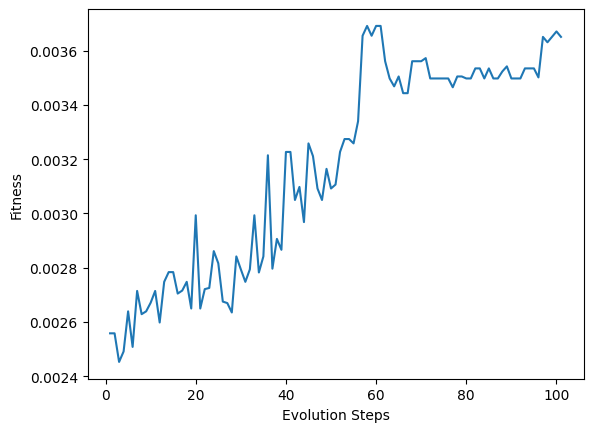

In [59]:
gene.print_fitness_evolution()

## Experiments

single_point, insert: terminated by converge
single_point, insert: terminated by maximum num of generations
single_point, inversion: terminated by converge
single_point, inversion: terminated by maximum num of generations
single_point, swap: terminated by converge
single_point, swap: terminated by maximum num of generations
single_point, scramble: terminated by converge
single_point, scramble: terminated by maximum num of generations
two_points, insert: terminated by maximum num of generations
two_points, inversion: terminated by converge
two_points, inversion: terminated by maximum num of generations
two_points, swap: terminated by converge
two_points, swap: terminated by maximum num of generations
two_points, scramble: terminated by converge
two_points, scramble: terminated by maximum num of generations
multi_points, insert: terminated by converge
multi_points, insert: terminated by maximum num of generations
multi_points, inversion: terminated by converge
multi_points, inversion: te

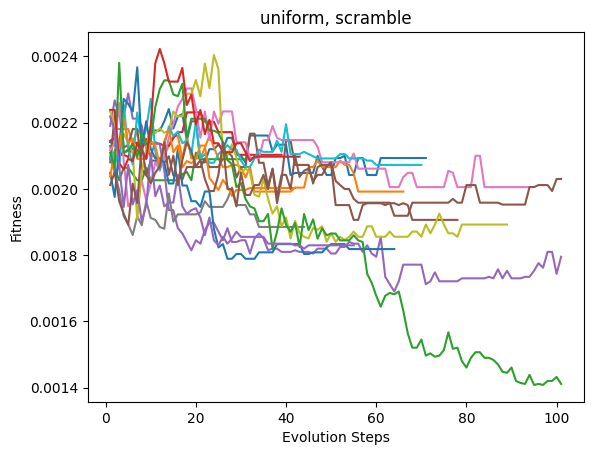

In [61]:
crossover_methods = ["single_point", "two_points", "multi_points", "uniform"]
mutation_methods = ["insert", "inversion", "swap", "scramble"]

gml_name = 'germany50--D-B-L-N-C-A-N-N.gml'
gml_file_name = 'sample_graph/' + gml_name
graph = read_graph_from_gml(gml_file_name)
g = Graph(adj_matrix=graph)
postmen, demands = read_postmen_and_demands(gml_name)

NUM_GENERATION = 100
POPULATION_SIZE = 10
MUTATION_RATE = 0.02
CONVERGE_STEP = 20
UNIFORM_CROSSOVER_RATE = 0.3

plts = []
for CROSSOVER in crossover_methods:
    plts.append([])
    for MUTATION in mutation_methods:
        gene = Gene(graph=g, 
                    postmen=postmen, 
                    demands=demands, 
                    population_size=POPULATION_SIZE, 
                    mutation_rate=MUTATION_RATE, 
                    num_generations=NUM_GENERATION, 
                    crossover_method=CROSSOVER, 
                    mutation_operator = MUTATION, 
                    uniform_crossover_rate=UNIFORM_CROSSOVER_RATE)
        gene.create_population()
        gene.evolution()
        plts[-1].append(gene.print_fitness_evolution())